In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numba

from numba import prange

from plot_functions import plot_connections, plot_poblacion
from main_functions import generate_vecinos, generate_vecinos_int, generate_vecinos_array
from main_functions import init_poblacion, temperatura_critica

plt.style.use(['science', 'notebook'])

# Vecinos aleatorios.
Pasamos de trabajar a primeros vecinos a seleccionar los vecinos de forma aleatoria, como queremos que los contactos se mantengan a lo largo del ensayo los almacenamos en un diccionario de la siguiente manera

In [2]:
N = 3
num = 2
vecinos_dict = {(x0, y0) : generate_vecinos(x0, y0, num, N) for x0 in range(N) for y0 in range(N)}
vecinos_dict

{(0, 0): ([1, 0], [2, 2]),
 (0, 1): ([2, 0], [0, 2]),
 (0, 2): ([1, 1], [1, 1]),
 (1, 0): ([0, 2], [0, 2]),
 (1, 1): ([2, 0], [1, 2]),
 (1, 2): ([0, 2], [2, 1]),
 (2, 0): ([0, 2], [0, 2]),
 (2, 1): ([0, 1], [0, 1]),
 (2, 2): ([0, 1], [2, 2])}

In [3]:
@numba.njit(parallel=True, nogil=True)
def metropolis(lattice, steps, T, num):
    """ funcion realiza una simulacion de montecarlo del modelo 
        de ising utilizando el algoritmo de metropolis teniendo 
        en cuenta que ahora los vecinos se toman aleatoriamente
        - inputs: 
            - lattice: matrix NxN con elementos +-1
            - steps: pasos de montecarlo
            - T: temperatura del sistema
            - num: numero de vecinos de cada individuo
        - outputs: 
            - lattice: estado final de la red
            - spins_sum: vector 1xsteps que contiene np.sum(lattice)
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.zeros(steps)
    vecinos_dict = generate_vecinos_int(num, N)
    
    for step in prange(steps):
        x, y = np.random.randint(0, N, 2) 
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        # calculo de la opinion de los 4 vecinos
        vecinos = vecinos_dict[x, y]
        # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
        # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
        S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice)
            
    return spins_sum

## Estudio de la temperatura crítica. 
Se analizará como depende la temperatura crítica con el número de contactos que tiene cada individuo y con el tamaño de la población. Además, se compará con el modelo de primeros vecinos visto anteriormente

In [4]:
@numba.njit(parallel=True, nogil=True)
def magnetizacion_T(N, prob, T_arr, steps, num):
    """ funcion que devuelve la magnetizacion por individuo
        una vez el sistema se ha relajado para una serie de 
        temperaturas
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - steps: pasos de montecarlo
        - outputs:
            - m_n: magnetizacion 1 x steps para poblacion con sesgo 
                    negativo
            - m_p: magnetizacion 1 x steps para poblacion con sesgo 
                    positivo
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()

    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))

    for i in prange(len(T_arr)):
        T = T_arr[i]
        spins = metropolis(pob_n, steps, T, num)
        m_n[i] = np.mean(spins[-10000:]/N**2)
        spins = metropolis(pob_p, steps, T, num)
        m_p[i] = np.mean(spins[-10000:]/N**2)
    return m_n, m_p

In [5]:
%%time
N = 20
# numero de contactos
num = 4
# pasos de montecarlo
steps = 2000000
# array de temperaturas
T_arr = np.linspace(0.01, 10)

m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps, num)

CPU times: total: 9min 41s
Wall time: 1min 26s


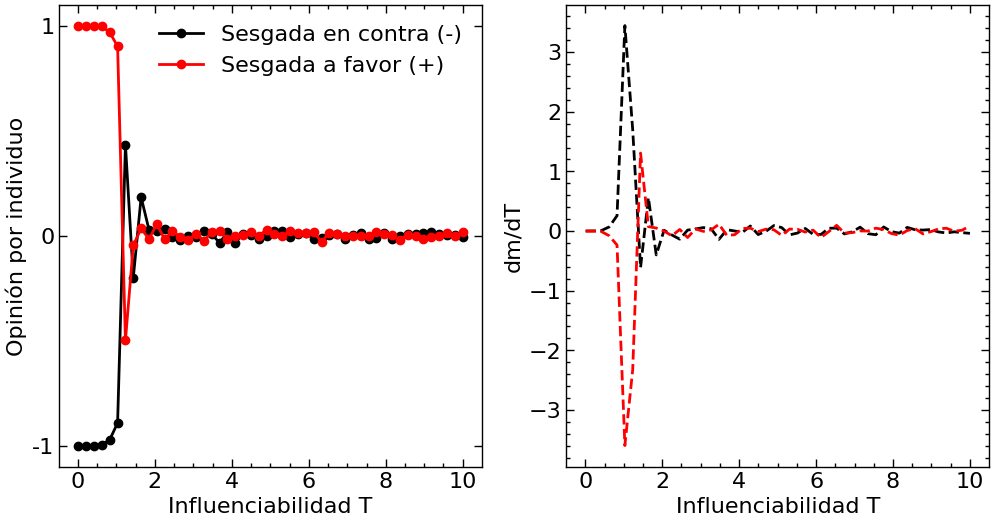

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(T_arr, m_n, 'k-o', label='Sesgada en contra (-)')
ax1.plot(T_arr, m_p, 'r-o', label='Sesgada a favor (+)')
ax1.set_xlabel('Influenciabilidad T')
ax1.set_ylabel('Opinión por individuo')
ax1.set_yticks([1, 0, -1], labels=['1', '0', '-1'])
ax1.legend()

ax2.plot(T_arr, np.gradient(m_n, T_arr), 'k--')
ax2.plot(T_arr, np.gradient(m_p, T_arr), 'r--')
ax2.set_xlabel('Influenciabilidad T')
ax2.set_ylabel('dm/dT')

plt.show()

In [9]:
# fig.savefig('IMAGENES/opinion_T_nu.png')

### Temperatura critica promediada

In [13]:
print(f'Calculo final Tc = {temperatura_critica(T_arr, m_p, m_n):.2f}')

Calculo final Tc = 1.23


### Dependencia de Tc con N

In [14]:
%%time
@numba.njit(parallel=True, nogil=True)
def numba_op(N_arr, steps, num):
    """ funcion que calcula la dependencia de la 
        temperatura critica con el tamaño de la 
        poblacion NxN
        - inputs: 
            - N_arr: array con los tamaños a estudiar
            - steps: pasos de montecarlo
        - outputs: 
            - Tc_arr: temperatura critica por N dado
    """
    # array de temperaturas
    T_arr = np.linspace(0.01, 10)
    # prealocamos la Tc
    Tc = np.empty(len(N_arr))

    for i in prange(len(N_arr)):
        N = N_arr[i]
        m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps[i], num)
        Tc[i] = temperatura_critica(T_arr, m_p, m_n)
        print(f'N: {N} Done')
    return Tc
N_arr = np.arange(10, 50, 5)
# valores tomados del script a primeros vecinos:
steps = np.array([98886, 142531, 205440, 296115, 
                  426812, 615194, 886722, 1278094], dtype=int)
num = 4
Tc = numba_op(N_arr, steps, 4)

N: 10 Done
N: 15 Done
N: 20 Done
N: 25 Done
N: 30 Done
N: 35 Done
N: 40 Done
N: 45 Done
CPU times: total: 27min 17s
Wall time: 3min 57s


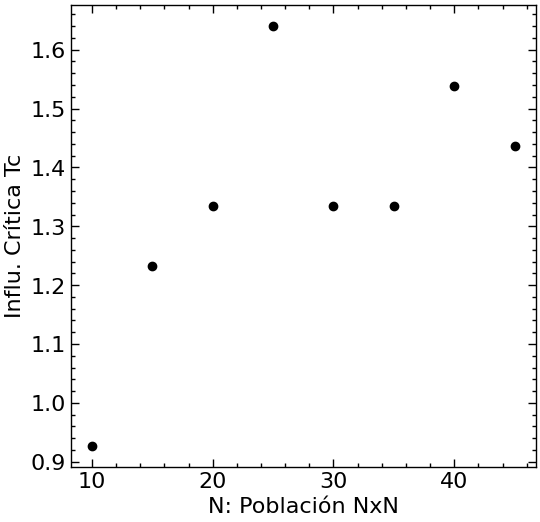

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(N_arr, Tc, 'ko')
ax.set_xlabel('N: Población NxN')
ax.set_ylabel('Influ. Crítica Tc')
plt.show()

In [16]:
# fig.savefig('IMAGENES/T_N_nu_4.png')

## Temperatura crítica en función del número de contactos

In [18]:
@numba.njit(parallel=True, nogil=True)
def temperatura_critica_nu(N, prob, T_arr, nu_arr, steps):
    """ funcion que calcula la temperatura critica en funcion 
        del valor nu (vecinos por individuo)
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - nu_arr: array con los valores de nu
            - steps: pasos de montecarlo
        - outputs:
            - Tc_arr: array con las Tc por nu
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()
    # prealocar t critic
    Tc_arr = np.empty(len(nu_arr))
    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))
    for n in range(len(nu_arr)):
        nu = nu_arr[n]
        print(nu, ' ok')
        for i in prange(len(T_arr)):
            T = T_arr[i]
            spins = metropolis(pob_n, steps, T, nu)
            m_n[i] = np.mean(spins[-10000:])
            spins = metropolis(pob_p, steps, T, nu)
            m_p[i] = np.mean(spins[-10000:])
        Tc_arr[n] = temperatura_critica(T_arr, m_p/N**2, m_n/N**2)
    return Tc_arr

In [19]:
%%time

N = 20
prob = 0.75
# pasos de montecarlo
steps = 200000
# array de temperaturas
T_arr = np.linspace(0.01, 10)
# numero de vecinos 1, 2, 3, nu_max
nu_arr = np.arange(1, 20+1)

Tc_arr = temperatura_critica_nu(N, prob, T_arr, nu_arr, steps)

1  ok
2  ok
3  ok
4  ok
5  ok
6  ok
7  ok
8  ok
9  ok
10  ok
11  ok
12  ok
13  ok
14  ok
15  ok
16  ok
17  ok
18  ok
19  ok
20  ok
CPU times: total: 18min 44s
Wall time: 2min 37s


In [20]:
print(np.max(Tc_arr))

8.572857142857142


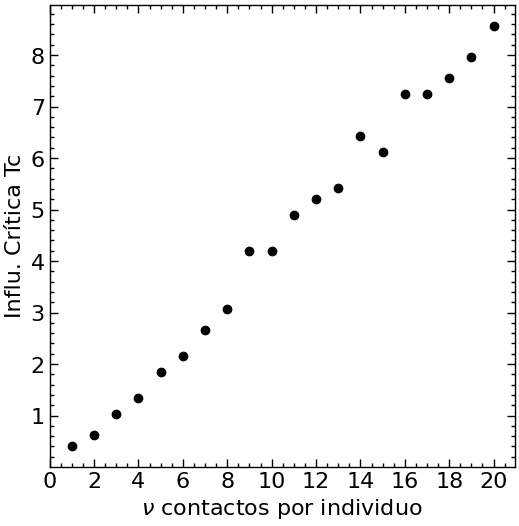

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(nu_arr, Tc_arr, 'ko')
ax.set_xticks(list(range(0, 20+2, 2)))
ax.set_xlabel(r'$\nu$ contactos por individuo')
ax.set_ylabel('Influ. Crítica Tc')
plt.show()

In [22]:
# fig.savefig('IMAGENES/T_N_nu_arr.png')

### Distribución gaussiana del número de contactos

In [23]:
@numba.njit(parallel=True, nogil=True)
def metropolis_array(lattice, steps, T, num):
    """ adaptacion de la funcion de metropolis definada 
        anteriormente para que reciba un num en forma de 
        matriz que contiene un numero particular de 
        contactos asociado a cada indiviudo
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.zeros(steps)
    vecinos_dict = generate_vecinos_array(num, N)
    
    for step in prange(steps):
        x, y = np.random.randint(0, N, 2) 
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        # calculo de la opinion de los 4 vecinos
        vecinos = vecinos_dict[x, y]
        # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
        # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
        S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice)
            
    return spins_sum

In [24]:
N = 20
mu = 5
sigma = 4
dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
dist_lattice[dist_lattice<1] = mu
dist_lattice[dist_lattice>N] = N


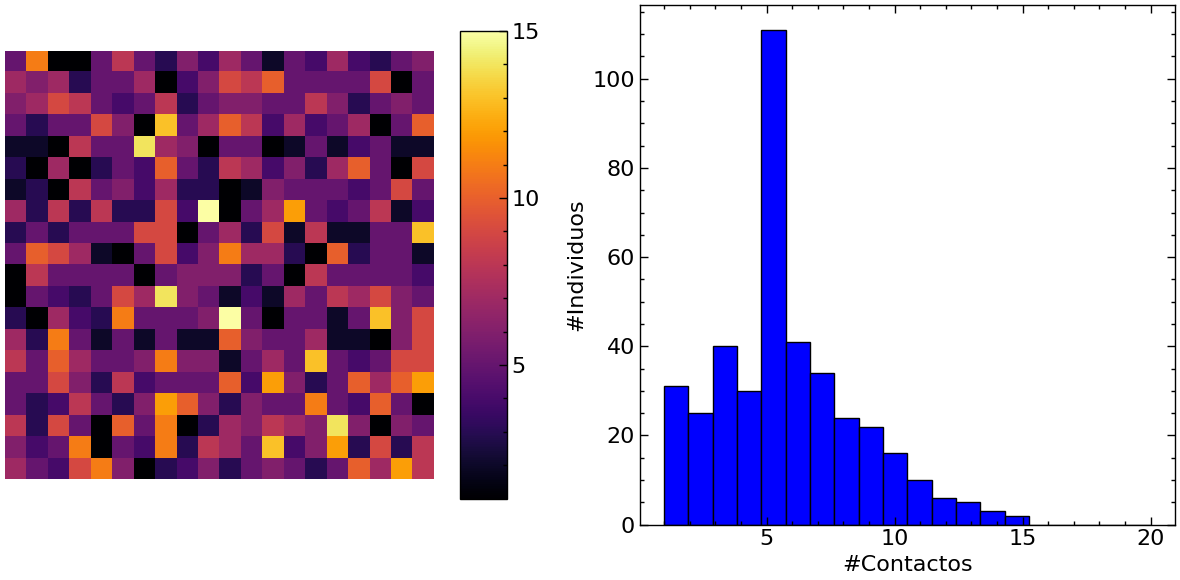

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im = ax1.imshow(dist_lattice, cmap='inferno')
ax1.set_axis_off()
plt.colorbar(im, ax=ax1, aspect=10, shrink=0.9, ticks=list(range(0,20+5, 5)))
_ = ax2.hist(dist_lattice.flatten(), range=(1, N), bins=20, color='blue', edgecolor='k')
ax2.set_ylabel('#Individuos')
ax2.set_xlabel('#Contactos')
plt.tight_layout()

In [26]:
# fig.savefig('IMAGENES/gauss_distr.png')

In [27]:
@numba.njit(parallel=True, nogil=True)
def temperatura_critica_sigma(N, prob, T_arr, dist_lattice, steps):
    """ funcion que calcula la temperatura critica en funcion 
        del valor mu y sigma para una distribucion de contactos 
        por vecino gausiana
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - dist_lattice: array con contactos por individuo
            - steps: pasos de montecarlo
        - outputs:
            - Tc_arr: array con las Tc por nu
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()

    
    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))

    for i in prange(len(T_arr)):
        T = T_arr[i]
        spins = metropolis_array(pob_n, steps, T, dist_lattice)
        m_n[i] = np.mean(spins[-10000:])
        spins = metropolis_array(pob_p, steps, T, dist_lattice)
        m_p[i] = np.mean(spins[-10000:])
    Tc_arr = temperatura_critica(T_arr, m_p/N**2, m_n/N**2)
    return Tc_arr

In [28]:
%%time

N = 20
prob = 0.75
# pasos de montecarlo
steps = 250000
# array de temperaturas
T_arr = np.linspace(0.01, 10)
# numero de vecinos 1, 2, 3, nu_max
sigma_arr = np.arange(5, N-5)

mu = 5
sigma_arr = np.arange(4, 15+1)
Tc_arr = np.empty(len(sigma_arr))
for n, sigma in enumerate(sigma_arr):
    print(sigma, ' ok')
    dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
    dist_lattice[dist_lattice<1] = mu
    dist_lattice[dist_lattice>N] = N

    Tc_arr[n] = temperatura_critica_sigma(N, prob, T_arr, dist_lattice, steps)

4  ok
5  ok
6  ok
7  ok
8  ok
9  ok
10  ok
11  ok
12  ok
13  ok
14  ok
15  ok
CPU times: total: 12min 45s
Wall time: 1min 51s


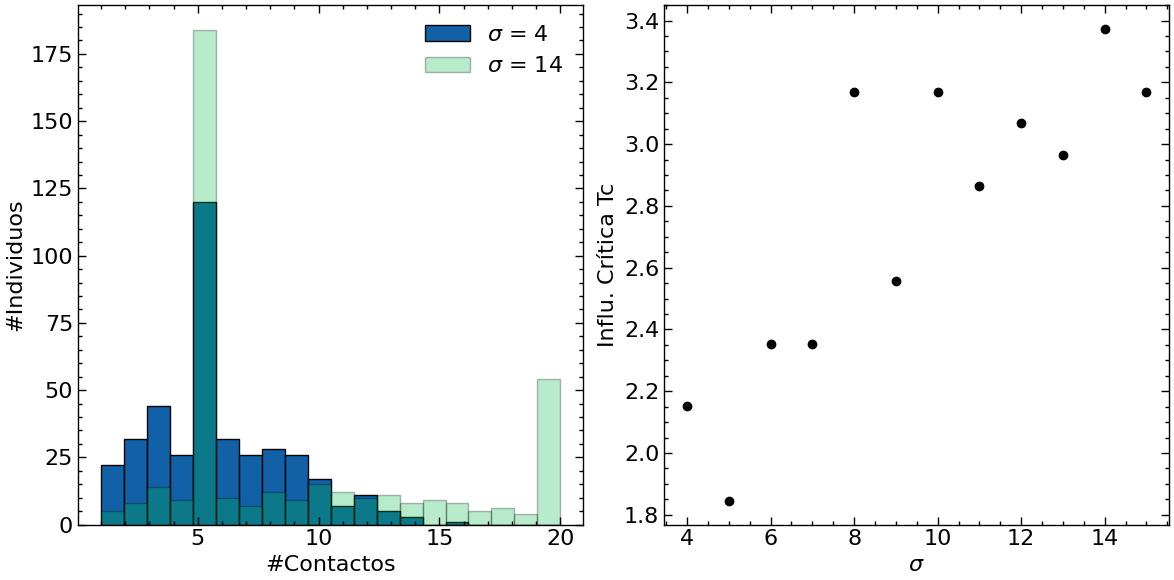

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N = 20
mu = 5

for sigma in [4, 14]:
    dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
    dist_lattice[dist_lattice<1] = mu
    dist_lattice[dist_lattice>N] = N
    _ = ax1.hist(dist_lattice.flatten(), range=(1, N), bins=20, edgecolor='k', alpha=3.9/sigma, label=r'$\sigma$ = '+str(sigma))
    ax1.set_ylabel('#Individuos')
    ax1.set_xlabel('#Contactos')
ax1.legend()
ax2.plot(sigma_arr, Tc_arr, 'ko')
# ax.set_xticks(list(range(0, 20+2, 2)))
ax2.set_xlabel(r'$\sigma$')
ax2.set_ylabel('Influ. Crítica Tc')
plt.tight_layout()
plt.show()

In [60]:
# fig.savefig('IMAGENES/gauss_Tc.png')

## Comparación del tamaño de los cúmulos
### Mismo número de contactos por individuo

In [33]:
@numba.njit(parallel=True, nogil=True)
def metropolis_cumulos_int(lattice, steps, T, num):
    """ funcion analoga a las ateriores de metropolis pero 
        en vez de devolver la opinion por individuo devuelve 
        la distribucion de la red despues de steps pasos de 
        montecarlo
    """
    lattice = lattice.copy()
    N = len(lattice)

    vecinos_dict = generate_vecinos_int(num, N)
    
    for step in prange(steps):
        x, y = np.random.randint(0, N, 2) 
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        # calculo de la opinion de los 4 vecinos
        vecinos = vecinos_dict[x, y]
        # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
        # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
        S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
            
    return lattice

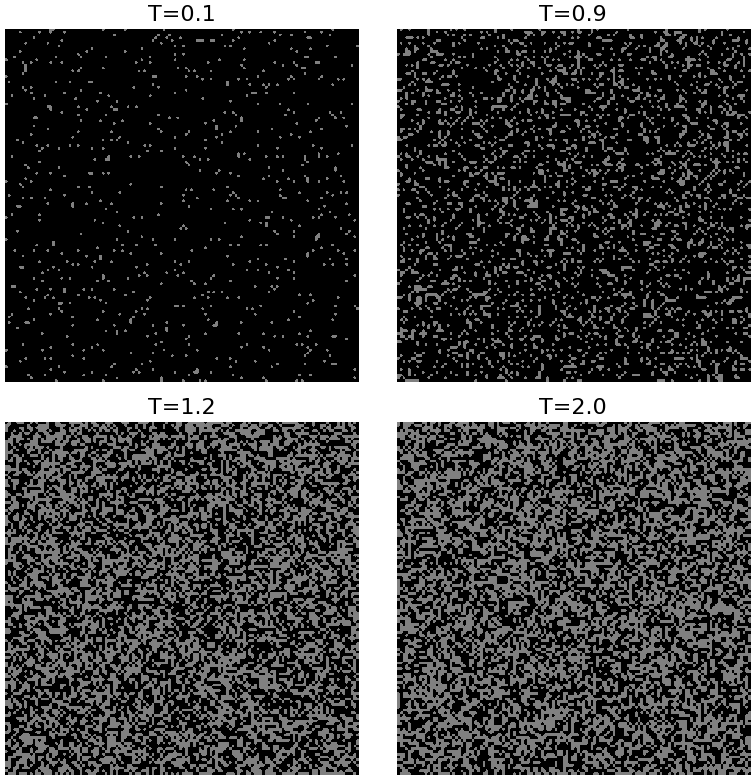

CPU times: total: 4.45 s
Wall time: 2.3 s


In [31]:
%%time
# Tamaño promedio de los cumulos
N = int(2**7)
nu = 6
montecarlo_steps = 100000
T_arr = [.1, .9, 1.2, 2.]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, T, in enumerate(T_arr):
    lattice = init_poblacion(N, 0.5)
    lattice_final = metropolis_cumulos_int(lattice, montecarlo_steps, T, nu)
    plot_poblacion(lattice_final, axes.flatten()[i], cb=False)
    axes.flatten()[i].set_title(f'T={T}')
plt.tight_layout()
plt.show()

In [32]:
# fig.savefig('IMAGENES/tamaño_cumulo_int.png')

### Distribución gaussiana de los contactos
sigma = 14

In [34]:
@numba.njit(parallel=True, nogil=True)
def metropolis_cumulos_array(lattice, steps, T, num):
    """ funcion analoga a las ateriores de metropolis pero 
        en vez de devolver la opinion por individuo devuelve 
        la distribucion de la red despues de steps pasos de 
        montecarlo
    """
    lattice = lattice.copy()
    N = len(lattice)
    vecinos_dict = generate_vecinos_array(num, N)
    
    for step in prange(steps):
        x, y = np.random.randint(0, N, 2) 
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        # calculo de la opinion de los 4 vecinos
        vecinos = vecinos_dict[x, y]
        # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
        # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
        S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
            
    return lattice

In [35]:
N = int(2**7)
mu = 5
sigma = 14
dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
dist_lattice[dist_lattice<1] = mu
dist_lattice[dist_lattice>N] = N

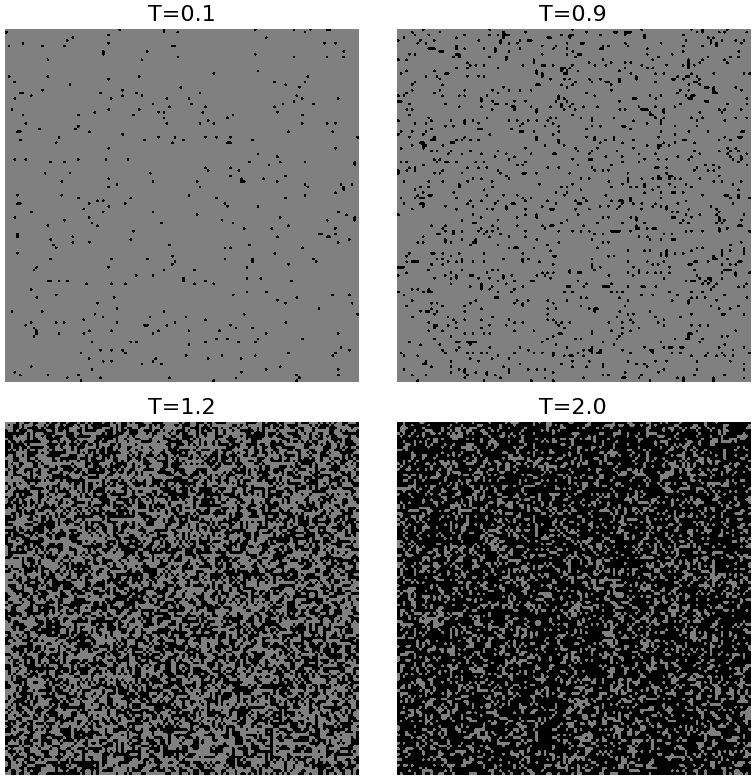

CPU times: total: 5.22 s
Wall time: 2.35 s


In [36]:
%%time
montecarlo_steps = 100000
T_arr = [.1, .9, 1.2, 2.]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, T, in enumerate(T_arr):
    lattice = init_poblacion(N, 0.5)
    lattice_final = metropolis_cumulos_array(lattice, montecarlo_steps, T, dist_lattice)
    plot_poblacion(lattice_final, axes.flatten()[i], cb=False)
    axes.flatten()[i].set_title(f'T={T}')
plt.tight_layout()
plt.show()

In [64]:
# fig.savefig('IMAGENES/tamaño_cumulo_array.png')